In [138]:
# Library
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime

import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from main import model_0_0, model_0_1, model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8
from main import model_t_1, model_t_2, model_t_3, model_t_4, model_t_5, model_t_6, model_t_7, model_t_8,model_tz_1, model_tz_2, model_tz_3, model_tz_4, model_tz_5, model_tz_6, model_tz_7, model_tz_8
from main import model_z_1, model_z_2, model_z_3, model_z_4, model_z_5, model_z_6, model_z_7, model_z_8

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()


def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
    
def plot_model(model_number, title, data):
    idata = globals()[f"idata_{model_number}"]
    if "sigma_eta" in idata.posterior.data_vars:
        z_mean = globals()[f"z_mean_{model_number}"]
        theta_mean = float(idata.posterior["theta"].mean(dim=["chain", "draw"]))
    else:
        z_mean = np.zeros(len(data["DATE"]))
        theta_mean = 0
    if "sigma_kappa" in idata.posterior.data_vars:
        kappa_mean = globals()[f"kappa_mean_{model_number}"]
    else:
        kappa_mean = float(idata.posterior["kappa"].mean(dim=["chain", "draw"]))

    alpha_mean = float(idata.posterior["alpha"].mean(dim=["chain", "draw"])) if "alpha" in idata.posterior.data_vars else 0
    beta_mean  = float(idata.posterior["beta"].mean(dim=["chain", "draw"]))
    pi_pred = alpha_mean * data["pi_prev"] + beta_mean * data["Epi"] + kappa_mean * data["Y"] - theta_mean * z_mean
    plt.figure(figsize=(8, 4))
    plt.plot(data["DATE"], pi_pred, label="prediction", color="blue")
    plt.plot(data["DATE"], data["pi"], label="observation", color="red")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("pi_t")
    plt.legend()
    plt.grid(True)
    plt.show()


---
## Real data
### Frequency
Quarterly (1982Q1-2024Q3)
### Output gap
Beveridge-Nelson Filter's cycle component (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

1/4 $\times$ (one year inflation expectation)
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

### The number of Firm
ECNSVY Business Dynamics Statistics (https://data.census.gov/table/BDSTIMESERIES.BDSGEO?q=Bussiness+dynamics+statistics)

---

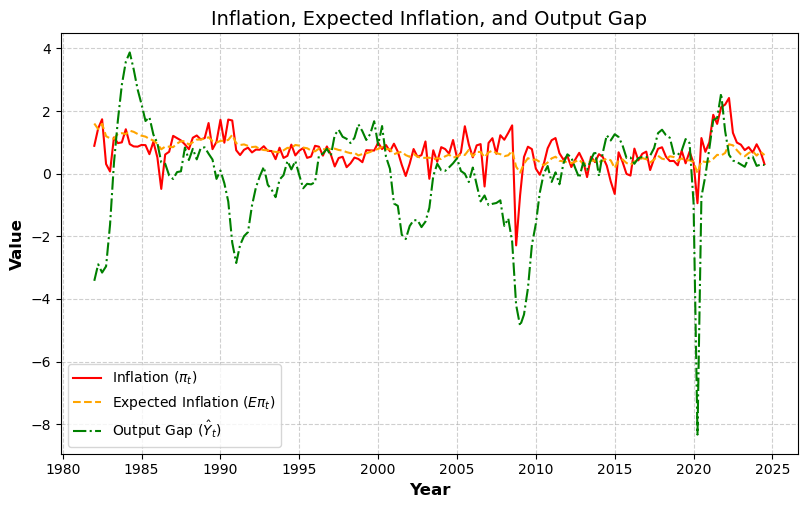

In [139]:
# Data cleaning and plot
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])


data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data.dropna(inplace=True)
# data = data[data['DATE'] < '2008-07-01']

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])

# plot
plt.figure(figsize=(8, 5))
plt.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')       
plt.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(data["DATE"], data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation parameters

In [140]:
warmup= 10000
samples=15000
chains = 2
rng_key = jax.random.PRNGKey(0)

# Normal NKPC

- Model 0-0
$$
\pi_t = \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

- Model 0-1 ($\alpha$ + $\beta$ = 1)
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$

In [141]:
# RUN MCMC
kernel = NUTS(model_0_0)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y)
idata_0_0 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_0_kappa = posterior_samples["kappa"].mean()
model_0_0_beta = posterior_samples["beta"].mean()
result_0_0=rf"""
$$\pi_{{t}} = {model_0_0_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_0_kappa:.4f}\, Y_t + \epsilon_t$$
"""


# RUN MCMC
kernel = NUTS(model_0_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y)
idata_0_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
model_0_1_kappa  = posterior_samples["kappa"].mean()
model_0_1_beta = posterior_samples["beta"].mean()
model_0_1_alpha = posterior_samples["alpha"].mean()

result_0_1=rf"""
$$\pi_{{t}} = {model_0_1_alpha:.4f}\, \pi_{{t-1}} + {model_0_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_0_1_kappa:.4f}\, Y_t + \epsilon_t$$
"""

sample: 100%|██████████| 25000/25000 [00:03<00:00, 6442.42it/s, 7 steps of size 5.95e-01. acc. prob=0.93]


In [142]:
dict_idata = {'Model-0-0':idata_0_0,'Model-0-1':idata_0_1}

params = ["alpha","beta","kappa"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"

    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.05).sum()
    row["n_bad_rhat"] = n_bad_rhat
    

    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)
# display(Markdown(result_0_0))
# display(Markdown(result_0_1))

,model,alpha,beta,kappa,n_bad_rhat
0,Model-0-0,-,0.960,0.066,0
1,Model-0-1,0.237,0.763,0.062,0


## HSA NKPC:

$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$

- Note: $\alpha$ + $\beta$ = 1
- Models' state equation
    - Model 1,2:  $\quad z_t = \gamma z_{{t-1}} + \eta_t$
    - Model 3,4:  $\quad z_t = \rho \hat{Y}_{{t-1}} + \eta_t$
    - Model 5,6:  $\quad z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$  
    - Model 7,8:  $\quad z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$ 

In [143]:
# RUN MCMC
print("Estimating Model 1...")
kernel = NUTS(model_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_1 = z_mean_1 - 1.96 * z_std     
z_upper_1 = z_mean_1 + 1.96 * z_std  

model_1_kappa = posterior_samples["kappa"].mean()
model_1_theta = posterior_samples["theta"].mean()
model_1_beta  = posterior_samples["beta"].mean()
model_1_gamma  = posterior_samples["gamma"].mean()

result_1=rf"""
$$\pi_{{t}} = {model_1_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_1_kappa:.4f}\, Y_t - {model_1_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_1_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""

# RUN MCMC
print("Estimating Model 2...")
kernel = NUTS(model_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_2 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_2 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_2 = z_mean_2 - 1.96 * z_std     
z_upper_2 = z_mean_2 + 1.96 * z_std    

model_2_kappa = posterior_samples["kappa"].mean()
model_2_alpha = posterior_samples["alpha"].mean()
model_2_theta = posterior_samples["theta"].mean()
model_2_beta = posterior_samples["beta"].mean()
model_2_gamma = posterior_samples["gamma"].mean()

result_2=rf"""
$$\pi_{{t}} = {model_2_alpha:.4f}\, \pi_{{t-1}} + {model_2_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_2_kappa:.4f}\, Y_t - {model_2_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_2_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""

# RUN MCMC
print("Estimating Model 3...")
kernel = NUTS(model_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_3 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_3 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_3 = z_mean_3 - 1.96 * z_std     
z_upper_3 = z_mean_3 + 1.96 * z_std  

model_3_kappa = posterior_samples["kappa"].mean()
model_3_theta = posterior_samples["theta"].mean()
model_3_beta = posterior_samples["beta"].mean()
model_3_rho = posterior_samples["rho"].mean()

result_3=rf"""
$$\pi_{{t}} = {model_3_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_3_kappa:.4f}\, Y_t - {model_3_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_3_rho:.4f}  Y_{{t-1}} + \eta_t$$
"""

# RUN MCMC
print("Estimating Model 4...")
kernel = NUTS(model_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_4 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]

z_mean_4 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_4 = z_mean_4 - 1.96 * z_std     
z_upper_4 = z_mean_4 + 1.96 * z_std  

model_4_alpha = posterior_samples["alpha"].mean()
model_4_kappa = posterior_samples["kappa"].mean()
model_4_theta = posterior_samples["theta"].mean()
model_4_beta = posterior_samples["beta"].mean()
model_4_rho = posterior_samples["rho"].mean()

result_4=rf"""
$$\pi_{{t}} = {model_4_alpha:.4f}\, \pi_{{t-1}} + {model_4_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_4_kappa:.4f}\, Y_t - {model_4_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_4_rho:.4f}  Y_{{t-1}} + \eta_t$$
"""


# RUN MCMC
print("Estimating Model 5...")
kernel = NUTS(model_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_5 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_5 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_5 = z_mean_5 - 1.96 * z_std     
z_upper_5 = z_mean_5 + 1.96 * z_std  

model_5_kappa = posterior_samples["kappa"].mean()
model_5_theta = posterior_samples["theta"].mean()
model_5_beta = posterior_samples["beta"].mean()
model_5_gamma = posterior_samples["gamma"].mean()
model_5_rho = posterior_samples["rho"].mean()

result_5=rf"""
$$\pi_{{t}} = {model_5_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_5_kappa:.4f}\, Y_t - {model_5_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} =  {model_5_rho:.4f}  Y_{{t-1}} + {model_5_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""


# RUN MCMC
print("Estimating Model 6...")
kernel = NUTS(model_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_6 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_6 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_6 = z_mean_6 - 1.96 * z_std     
z_upper_6 = z_mean_6 + 1.96 * z_std  

model_6_alpha = posterior_samples["alpha"].mean()
model_6_kappa = posterior_samples["kappa"].mean()
model_6_theta = posterior_samples["theta"].mean()
model_6_beta = posterior_samples["beta"].mean()
model_6_gamma = posterior_samples["gamma"].mean()
model_6_rho = posterior_samples["rho"].mean()

result_6=rf"""
$$\pi_{{t}} = {model_6_alpha:.4f}\, \pi_{{t-1}} + {model_6_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_6_kappa:.4f}\, Y_t - {model_6_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_6_rho:.4f}  Y_{{t-1}} + {model_6_gamma:.4f}  z_{{t-1}} + \eta_t$$
"""


# RUN MCMC
print("Estimating Model 7...")
kernel = NUTS(model_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=False)
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_7 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_7 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_7 = z_mean_7 - 1.96 * z_std     
z_upper_7 = z_mean_7 + 1.96 * z_std  

model_7_kappa = posterior_samples["kappa"].mean()
model_7_beta = posterior_samples["beta"].mean()
model_7_theta = posterior_samples["theta"].mean()
model_7_gamma = posterior_samples["gamma"].mean()
model_7_delta = posterior_samples["delta"].mean()
model_7_rho = posterior_samples["rho"].mean()

result_7=rf"""
$$\pi_{{t}} = {model_7_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_7_kappa:.4f}\, Y_t - {model_7_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_7_rho:.4f}  Y_{{t-1}} + {model_7_gamma:.4f}  z_{{t-1}} + {model_7_delta:.4f}  \pi_{{t-1}} + \eta_t$$
"""

# RUN MCMC
print("Estimating Model 8...")
kernel = NUTS(model_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=False)
mcmc.run(rng_key, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, Y=Y,Y_prev=Y_prev, l=len(pi))
idata_8 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_8 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_8 = z_mean_8 - 1.97 * z_std     
z_upper_8 = z_mean_8 + 1.97 * z_std  

model_8_alpha = posterior_samples["alpha"].mean()
model_8_kappa = posterior_samples["kappa"].mean()
model_8_beta = posterior_samples["beta"].mean()
model_8_theta = posterior_samples["theta"].mean()
model_8_gamma = posterior_samples["gamma"].mean()
model_8_rho = posterior_samples["rho"].mean()
model_8_delta = posterior_samples["delta"].mean()

result_8=rf"""
$$\pi_{{t}} = {model_8_alpha:.4f}\, \pi_{{t-1}} + {model_8_beta:.4f}\, E_t[\pi_{{t+1}}] + {model_8_kappa:.4f}\, Y_t - {model_8_theta:.4f}\, z_t + \epsilon_t$$
$$z_{{t}} = {model_8_rho:.4f}  Y_{{t-1}} + {model_8_gamma:.4f}  z_{{t-1}} + {model_8_delta:.4f}  \pi_{{t-1}} + \eta_t$$
"""

Estimating Model 1...
Estimating Model 2...
Estimating Model 3...
Estimating Model 4...
Estimating Model 5...
Estimating Model 6...
Estimating Model 7...
Estimating Model 8...


In [144]:
dict_idata = {'Model-1':idata_1, 'Model-2':idata_2, 'Model-3':idata_3, 'Model-4':idata_4, 
              'Model-5':idata_5,'Model-6':idata_6, 'Model-7':idata_7,'Model-8':idata_8}

import re
def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None

params = ["alpha","beta", "kappa", "gamma", "rho", "delta"]

df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"
    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.05).sum()
    row["n_bad_rhat"] = n_bad_rhat
    

    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)
# display(Markdown(result_0_0))
# display(Markdown(result_0_1))
# display(Markdown(result_1))
# display(Markdown(result_2))
# display(Markdown(result_3))
# display(Markdown(result_4))
# display(Markdown(result_5))
# display(Markdown(result_6))
# display(Markdown(result_7))
# display(Markdown(result_8))


,model,alpha,beta,kappa,gamma,rho,delta,n_bad_rhat
0,Model-1,-,0.947,0.107,0.589,-,-,0
1,Model-2,0.04,0.960,0.101,0.582,-,-,0
2,Model-3,-,0.960,0.096,-,0.178,-,32
3,Model-4,0.28,0.720,0.118,-,0.269,-,0
4,Model-5,-,0.951,0.128,0.519,0.168,-,0
5,Model-6,0.04,0.960,0.108,0.439,0.199,-,178
6,Model-7,-,0.962,0.124,0.56,0.159,0.15,0
7,Model-8,0.057,0.943,0.126,0.501,0.179,0.154,0


## time-variant $\kappa$ ($z_{t-1}$)
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} = \rho_{z} z_{{t-1}} + u_t, ,\quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$
- Note: $\alpha$ + $\beta$ = 1
- Models' state equation
    - Model 9,10:  $\quad z_t = \gamma z_{{t-1}} + \eta_t$
    - Model 11,12:  $\quad z_t = \rho \hat{Y}_{{t-1}} + \eta_t$
    - Model 13,14:  $\quad z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$  
    - Model 15,16:  $\quad z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$ 

In [145]:
# Model 1
print("Estimating Model 9...")
kernel = NUTS(model_z_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_9 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()
# z
z_9_samples = posterior_samples["z"]
z_mean_9 = np.mean(z_9_samples, axis=0)
z_std_9 = np.std(z_9_samples, axis=0)
z_lower_9 = z_mean_9 - 1.96 * z_std_9
z_upper_9 = z_mean_9 + 1.96 * z_std_9

# kappa
kappa_9_samples = posterior_samples["kappa"]
kappa_mean_9 = np.mean(kappa_9_samples, axis=0)
kappa_std_9 = np.std(kappa_9_samples, axis=0)
kappa_lower_9 = kappa_mean_9 - 1.96 * kappa_std_9
kappa_upper_9 = kappa_mean_9 + 1.96 * kappa_std_9

model_9_theta = posterior_samples["theta"].mean()
model_9_beta  = posterior_samples["beta"].mean()
model_9_gamma = posterior_samples["gamma"].mean()
model_9_rho_z = posterior_samples["rho_z"].mean()

result_9 = rf"""
$$\pi_{{t}} = {model_9_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{1,t}} Y_t - {model_9_theta:.4f}\, z_{{1,t}} + \epsilon_t$$
$$z_{{1,t}} = {model_9_gamma:.4f}\, z_{{1,t-1}} + \eta_t$$
$$\kappa_{{1,t}} = {model_9_rho_z:.4f}\, z_{{1,t-1}} + u_t$$
"""

# Model 2
print("Estimating Model 10...")
kernel = NUTS(model_z_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_10 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_10_samples = posterior_samples["z"]
z_mean_10 = np.mean(z_10_samples, axis=0)
z_std_10 = np.std(z_10_samples, axis=0)
z_lower_10 = z_mean_2 - 1.96 * z_std_10
z_upper_10 = z_mean_2 + 1.96 * z_std_10

kappa_10_samples = posterior_samples["kappa"]
kappa_mean_10 = np.mean(kappa_10_samples, axis=0)
kappa_std_10 = np.std(kappa_10_samples, axis=0)
kappa_lower_10 = kappa_mean_10 - 1.96 * kappa_std_10
kappa_upper_10 = kappa_mean_10 + 1.96 * kappa_std_10

model_10_alpha = posterior_samples["alpha"].mean()
model_10_theta = posterior_samples["theta"].mean()
model_10_beta  = posterior_samples["beta"].mean()
model_10_gamma = posterior_samples["gamma"].mean()
model_10_rho_z = posterior_samples["rho_z"].mean()

result_10 = rf"""
$$\pi_{{t}} = {model_10_alpha:.4f}\, \pi_{{t-1}} + {model_10_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{2,t}} Y_t - {model_10_theta:.4f}\, z_{{2,t}} + \epsilon_t$$
$$z_{{2,t}} = {model_10_gamma:.4f}\, z_{{2,t-1}} + \eta_t$$
$$\kappa_{{2,t}} = {model_10_rho_z:.4f}\, z_{{2,t-1}} + u_t$$
"""

# Model 3
print("Estimating Model 11...")
kernel = NUTS(model_z_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_11 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_11_samples = posterior_samples["z"]
z_mean_11 = np.mean(z_11_samples, axis=0)
z_std_11 = np.std(z_11_samples, axis=0)
z_lower_11 = z_mean_11 - 1.96 * z_std_11
z_upper_11 = z_mean_11 + 1.96 * z_std_11

kappa_11_samples = posterior_samples["kappa"]
kappa_mean_11 = np.mean(kappa_11_samples, axis=0)
kappa_std_11 = np.std(kappa_11_samples, axis=0)
kappa_lower_11 = kappa_mean_11 - 1.96 * kappa_std_11
kappa_upper_11 = kappa_mean_11 + 1.96 * kappa_std_11

model_11_theta = posterior_samples["theta"].mean()
model_11_beta  = posterior_samples["beta"].mean()
model_11_gamma = posterior_samples["gamma"].mean()
model_11_rho   = posterior_samples["rho"].mean()
model_11_rho_z = posterior_samples["rho_z"].mean()

result_11 = rf"""
$$\pi_{{t}} = {model_11_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{3,t}} Y_t - {model_11_theta:.4f}\, z_{{3,t}} + \epsilon_t$$
$$z_{{3,t}} = {model_11_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{3,t}} = {model_11_rho_z:.4f}\, z_{{3,t-1}} + u_t$$
"""

# Model 4
print("Estimating Model 12...")
kernel = NUTS(model_z_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_12 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_12_samples = posterior_samples["z"]
z_mean_12 = np.mean(z_12_samples, axis=0)
z_std_12 = np.std(z_12_samples, axis=0)
z_lower_12 = z_mean_4 - 1.96 * z_std_12
z_upper_12 = z_mean_4 + 1.96 * z_std_12

kappa_12_samples = posterior_samples["kappa"]
kappa_mean_12 = np.mean(kappa_12_samples, axis=0)
kappa_std_12 = np.std(kappa_12_samples, axis=0)
kappa_lower_12 = kappa_mean_12 - 1.96 * kappa_std_12
kappa_upper_12 = kappa_mean_12 + 1.96 * kappa_std_12

model_12_alpha = posterior_samples["alpha"].mean()
model_12_theta = posterior_samples["theta"].mean()
model_12_beta  = posterior_samples["beta"].mean()
model_12_rho   = posterior_samples["rho"].mean()
model_12_gamma = posterior_samples["gamma"].mean()
model_12_rho_z = posterior_samples["rho_z"].mean()

result_12 = rf"""
$$\pi_{{t}} = {model_12_alpha:.4f}\, \pi_{{t-1}} + {model_12_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{4,t}} Y_t - {model_12_theta:.4f}\, z_{{4,t}} + \epsilon_t$$
$$z_{{4,t}} = {model_12_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{4,t}} = {model_12_rho_z:.4f}\, z_{{4,t-1}} + u_t$$
"""

# Model 5
print("Estimating Model 13...")
kernel = NUTS(model_z_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_13 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_13_samples = posterior_samples["z"]
z_mean_13 = np.mean(z_13_samples, axis=0)
z_std_13 = np.std(z_13_samples, axis=0)
z_lower_13 = z_mean_13 - 1.96 * z_std_13
z_upper_13 = z_mean_13 + 1.96 * z_std_13

kappa_13_samples = posterior_samples["kappa"]
kappa_mean_13 = np.mean(kappa_13_samples, axis=0)
kappa_std_13 = np.std(kappa_13_samples, axis=0)
kappa_lower_13 = kappa_mean_13 - 1.96 * kappa_std_13
kappa_upper_13 = kappa_mean_13 + 1.96 * kappa_std_13

model_13_theta = posterior_samples["theta"].mean()
model_13_beta  = posterior_samples["beta"].mean()
model_13_gamma = posterior_samples["gamma"].mean()
model_13_rho   = posterior_samples["rho"].mean()
model_13_rho_z = posterior_samples["rho_z"].mean()

result_13 = rf"""
$$\pi_{{t}} = {model_13_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{5,t}} Y_t - {model_13_theta:.4f}\, z_{{5,t}} + \epsilon_t$$
$$z_{{5,t}} = {model_13_rho:.4f}\, Y_{{t-1}} + {model_13_gamma:.4f}\, z_{{5,t-1}} + \eta_t$$
$$\kappa_{{5,t}} = {model_13_rho_z:.4f}\, z_{{5,t-1}} + u_t$$
"""

# Model 6
print("Estimating Model 14...")
kernel = NUTS(model_z_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_14 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_14_samples = posterior_samples["z"]
z_mean_14 = np.mean(z_14_samples, axis=0)
z_std_14 = np.std(z_14_samples, axis=0)
z_lower_14 = z_mean_6 - 1.96 * z_std_14
z_upper_14 = z_mean_6 + 1.96 * z_std_14

kappa_14_samples = posterior_samples["kappa"]
kappa_mean_14 = np.mean(kappa_14_samples, axis=0)
kappa_std_14 = np.std(kappa_14_samples, axis=0)
kappa_lower_14 = kappa_mean_14 - 1.96 * kappa_std_14
kappa_upper_14 = kappa_mean_14 + 1.96 * kappa_std_14

model_14_alpha = posterior_samples["alpha"].mean()
model_14_theta = posterior_samples["theta"].mean()
model_14_beta  = posterior_samples["beta"].mean()
model_14_gamma = posterior_samples["gamma"].mean()
model_14_rho   = posterior_samples["rho"].mean()
model_14_rho_z = posterior_samples["rho_z"].mean()

result_14 = rf"""
$$\pi_{{t}} = {model_14_alpha:.4f}\, \pi_{{t-1}} + {model_14_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{6,t}} Y_t - {model_14_theta:.4f}\, z_{{6,t}} + \epsilon_t$$
$$z_{{6,t}} = {model_14_rho:.4f}\, Y_{{t-1}} + {model_14_gamma:.4f}\, z_{{6,t-1}} + \eta_t$$
$$\kappa_{{6,t}} = {model_14_rho_z:.4f}\, z_{{6,t-1}} + u_t$$
"""

# Model 7
print("Estimating Model 15...")
kernel = NUTS(model_z_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_15 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_15_samples = posterior_samples["z"]
z_mean_15 = np.mean(z_15_samples, axis=0)
z_std_15 = np.std(z_15_samples, axis=0)
z_lower_15 = z_mean_15 - 1.96 * z_std_15
z_upper_15 = z_mean_15 + 1.96 * z_std_15

kappa_15_samples = posterior_samples["kappa"]
kappa_mean_15 = np.mean(kappa_15_samples, axis=0)
kappa_std_15 = np.std(kappa_15_samples, axis=0)
kappa_lower_15 = kappa_mean_15 - 1.96 * kappa_std_15
kappa_upper_15 = kappa_mean_15 + 1.96 * kappa_std_15

model_15_theta = posterior_samples["theta"].mean()
model_15_beta  = posterior_samples["beta"].mean()
model_15_gamma = posterior_samples["gamma"].mean()
model_15_delta = posterior_samples["delta"].mean()
model_15_rho   = posterior_samples["rho"].mean()
model_15_rho_z = posterior_samples["rho_z"].mean()

result_15 = rf"""
$$\pi_{{t}} = {model_15_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{7,t}} Y_t - {model_15_theta:.4f}\, z_{{7,t}} + \epsilon_t$$
$$z_{{7,t}} = {model_15_rho:.4f}\, Y_{{t-1}} + {model_15_gamma:.4f}\, z_{{7,t-1}} + {model_15_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{7,t}} = {model_15_rho_z:.4f}\, z_{{7,t-1}} + u_t$$
"""

# Model 8
print("Estimating Model 16...")
kernel = NUTS(model_z_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_16 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_16_samples = posterior_samples["z"]
z_mean_16 = np.mean(z_16_samples, axis=0)
z_std_16 = np.std(z_16_samples, axis=0)
z_lower_16 = z_mean_16 - 1.96 * z_std_16
z_upper_16 = z_mean_16 + 1.96 * z_std_16

kappa_16_samples = posterior_samples["kappa"]
kappa_mean_16 = np.mean(kappa_16_samples, axis=0)
kappa_std_16 = np.std(kappa_16_samples, axis=0)
kappa_lower_16 = kappa_mean_16 - 1.96 * kappa_std_16
kappa_upper_16 = kappa_mean_16 + 1.96 * kappa_std_16

model_16_alpha = posterior_samples["alpha"].mean()
model_16_beta  = posterior_samples["beta"].mean()
model_16_theta = posterior_samples["theta"].mean()
model_16_gamma = posterior_samples["gamma"].mean()
model_16_rho   = posterior_samples["rho"].mean()
model_16_delta = posterior_samples["delta"].mean()
model_16_rho_z = posterior_samples["rho_z"].mean()

result_16 = rf"""
$$\pi_{{t}} = {model_16_alpha:.4f}\, \pi_{{t-1}} + {model_16_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{8,t}} Y_t - {model_16_theta:.4f}\, z_{{8,t}} + \epsilon_t$$
$$z_{{8,t}} = {model_16_rho:.4f}\, Y_{{t-1}} + {model_16_gamma:.4f}\, z_{{8,t-1}} + {model_16_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{8,t}} = {model_16_rho_z:.4f}\, z_{{8,t-1}} + u_t$$
"""


Estimating Model 9...
Estimating Model 10...
Estimating Model 11...
Estimating Model 12...
Estimating Model 13...
Estimating Model 14...
Estimating Model 15...
Estimating Model 16...


In [146]:
dict_idata = {'Model-9':idata_9, 'Model-10':idata_10, 'Model-11':idata_11, 'Model-12':idata_12, 
              'Model-13':idata_13,'Model-14':idata_14, 'Model-15':idata_15,'Model-16':idata_16}

params = ["alpha","beta", "rho", "gamma", "delta", "rho_z"]

df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"
    

    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.05).sum()
    row["n_bad_rhat"] = n_bad_rhat
    

    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

# display(Markdown(result_t_z_1))
# display(Markdown(result_t_z_2))
# display(Markdown(result_t_z_3))
# display(Markdown(result_t_z_4))
# display(Markdown(result_t_z_5))
# display(Markdown(result_t_z_6))
# display(Markdown(result_t_z_7))
# display(Markdown(result_t_z_8))


,model,alpha,beta,rho,gamma,delta,rho_z,n_bad_rhat
0,Model-9,-,0.964,-,0.757,-,-0.096,0
1,Model-10,0.036,0.964,-,0.722,-,-0.111,0
2,Model-11,-,0.957,0.065,0.661,-,0.101,226
3,Model-12,0.136,0.864,-0.107,0.344,-,-0.037,0
4,Model-13,-,0.967,0.137,0.625,-,-0.091,0
5,Model-14,0.136,0.864,-0.107,0.344,-,-0.037,0
6,Model-15,-,0.970,0.143,0.640,0.096,-0.072,0
7,Model-16,0.056,0.944,0.163,0.575,0.097,-0.089,0


## time-variant $\kappa$ ($\kappa_{t-1}$)
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} = \rho_{\kappa} \kappa_{{t-1}} + u_t, ,\quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$
- Note: $\alpha$ + $\beta$ = 1
- Models' state equation
    - Model 17,18:  $\quad z_t = \gamma z_{{t-1}} + \eta_t$
    - Model 19,20:  $\quad z_t = \rho \hat{Y}_{{t-1}} + \eta_t$
    - Model 21,22:  $\quad z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$  
    - Model 23,24:  $\quad z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$ 

In [147]:
# --------------------
# Model t_17
# --------------------
print("Estimating Model 17...")
kernel = NUTS(model_t_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_17 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_17_samples = posterior_samples["z"]
z_mean_17 = np.mean(z_17_samples, axis=0)
z_std_17 = np.std(z_17_samples, axis=0)
z_lower_17 = z_mean_17 - 1.96 * z_std_17
z_upper_17 = z_mean_17 + 1.96 * z_std_17

kappa_17_samples = posterior_samples["kappa"]
kappa_mean_17 = np.mean(kappa_17_samples, axis=0)
kappa_std_17 = np.std(kappa_17_samples, axis=0)
kappa_lower_17 = kappa_mean_17 - 1.96 * kappa_std_17
kappa_upper_17 = kappa_mean_17 + 1.96 * kappa_std_17

model_17_theta    = posterior_samples["theta"].mean()
model_17_beta     = posterior_samples["beta"].mean()
model_17_gamma    = posterior_samples["gamma"].mean()
model_17_rho_kappa = posterior_samples["rho_kappa"].mean()

result_17 = rf"""
$$\pi_{{t}} = {model_17_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{1,t}} Y_t - {model_17_theta:.4f}\, z_{{1,t}} + \epsilon_t$$
$$z_{{1,t}} = {model_17_gamma:.4f}\, z_{{1,t-1}} + \eta_t$$
$$\kappa_{{1,t}} = {model_17_rho_kappa:.4f}\, \kappa_{{1,t-1}} + u_t$$
"""

# --------------------
# Model t_18
# --------------------
print("Estimating Model 18...")
kernel = NUTS(model_t_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_18 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_18_samples = posterior_samples["z"]
z_mean_18 = np.mean(z_18_samples, axis=0)
z_std_18 = np.std(z_18_samples, axis=0)
z_lower_18 = z_mean_18 - 1.96 * z_std_18
z_upper_18 = z_mean_18 + 1.96 * z_std_18

kappa_18_samples = posterior_samples["kappa"]
kappa_mean_18 = np.mean(kappa_18_samples, axis=0)
kappa_std_18 = np.std(kappa_18_samples, axis=0)
kappa_lower_18 = kappa_mean_18 - 1.96 * kappa_std_18
kappa_upper_18 = kappa_mean_18 + 1.96 * kappa_std_18

model_18_alpha    = posterior_samples["alpha"].mean()
model_18_theta    = posterior_samples["theta"].mean()
model_18_beta     = posterior_samples["beta"].mean()
model_18_gamma    = posterior_samples["gamma"].mean()
model_18_rho_kappa = posterior_samples["rho_kappa"].mean()

result_18 = rf"""
$$\pi_{{t}} = {model_18_alpha:.4f}\, \pi_{{t-1}} + {model_18_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{2,t}} Y_t - {model_18_theta:.4f}\, z_{{2,t}} + \epsilon_t$$
$$z_{{2,t}} = {model_18_gamma:.4f}\, z_{{2,t-1}} + \eta_t$$
$$\kappa_{{2,t}} = {model_18_rho_kappa:.4f}\, \kappa_{{2,t-1}} + u_t$$
"""


# --------------------
# Model t_19
# --------------------
print("Estimating Model 19...")
kernel = NUTS(model_t_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_19 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_19_samples = posterior_samples["z"]
z_mean_19 = np.mean(z_19_samples, axis=0)
z_std_19 = np.std(z_19_samples, axis=0)
z_lower_19 = z_mean_19 - 1.96 * z_std_19
z_upper_19 = z_mean_19 + 1.96 * z_std_19

kappa_19_samples = posterior_samples["kappa"]
kappa_mean_19 = np.mean(kappa_19_samples, axis=0)
kappa_std_19 = np.std(kappa_19_samples, axis=0)
kappa_lower_19 = kappa_mean_19 - 1.96 * kappa_std_19
kappa_upper_19 = kappa_mean_19 + 1.96 * kappa_std_19

model_19_theta    = posterior_samples["theta"].mean()
model_19_beta     = posterior_samples["beta"].mean()
model_19_rho      = posterior_samples["rho"].mean()
model_19_rho_kappa = posterior_samples["rho_kappa"].mean()

result_19 = rf"""
$$\pi_{{t}} = {model_19_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{3,t}} Y_t - {model_19_theta:.4f}\, z_{{3,t}} + \epsilon_t$$
$$z_{{3,t}} = {model_19_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{3,t}} = {model_19_rho_kappa:.4f}\, \kappa_{{3,t-1}} + u_t$$
"""


# --------------------
# Model t_20
# --------------------
print("Estimating Model 20...")
kernel = NUTS(model_t_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_20 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_20_samples = posterior_samples["z"]
z_mean_20 = np.mean(z_20_samples, axis=0)
z_std_20 = np.std(z_20_samples, axis=0)
z_lower_20 = z_mean_20 - 1.96 * z_std_20
z_upper_20 = z_mean_20 + 1.96 * z_std_20

kappa_20_samples = posterior_samples["kappa"]
kappa_mean_20 = np.mean(kappa_20_samples, axis=0)
kappa_std_20 = np.std(kappa_20_samples, axis=0)
kappa_lower_20 = kappa_mean_20 - 1.96 * kappa_std_20
kappa_upper_20 = kappa_mean_20 + 1.96 * kappa_std_20

model_20_theta    = posterior_samples["theta"].mean()
model_20_alpha    = posterior_samples["alpha"].mean()
model_20_beta     = posterior_samples["beta"].mean()
model_20_rho      = posterior_samples["rho"].mean()
model_20_rho_kappa = posterior_samples["rho_kappa"].mean()

result_20 = rf"""
$$\pi_{{t}} = {model_20_alpha:.4f}\, \pi_{{t-1}} + {model_20_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{4,t}} Y_t - {model_20_theta:.4f}\, z_{{4,t}} + \epsilon_t$$
$$z_{{4,t}} = {model_20_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{4,t}} = {model_20_rho_kappa:.4f}\, \kappa_{{4,t-1}} + u_t$$
"""


# --------------------
# Model t_5
# --------------------
print("Estimating Model 21...")
kernel = NUTS(model_t_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_21 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_21_samples = posterior_samples["z"]
z_mean_21 = np.mean(z_21_samples, axis=0)
z_std_21 = np.std(z_21_samples, axis=0)
z_lower_21 = z_mean_21 - 1.96 * z_std_21
z_upper_21 = z_mean_21 + 1.96 * z_std_21

kappa_21_samples = posterior_samples["kappa"]
kappa_mean_21 = np.mean(kappa_21_samples, axis=0)
kappa_std_21 = np.std(kappa_21_samples, axis=0)
kappa_lower_21 = kappa_mean_21 - 1.96 * kappa_std_21
kappa_upper_21 = kappa_mean_21 + 1.96 * kappa_std_21

model_21_theta    = posterior_samples["theta"].mean()
model_21_beta     = posterior_samples["beta"].mean()
model_21_gamma    = posterior_samples["gamma"].mean()
model_21_rho      = posterior_samples["rho"].mean()
model_21_rho_kappa = posterior_samples["rho_kappa"].mean()

result_21 = rf"""
$$\pi_{{t}} = {model_21_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{5,t}} Y_t - {model_21_theta:.4f}\, z_{{5,t}} + \epsilon_t$$
$$z_{{5,t}} = {model_21_rho:.4f}\, Y_{{t-1}} + {model_21_gamma:.4f}\, z_{{5,t-1}} + \eta_t$$
$$\kappa_{{5,t}} = {model_21_rho_kappa:.4f}\, \kappa_{{5,t-1}} + u_t$$
"""


# --------------------
# Model t_22
# --------------------
print("Estimating Model 22...")
kernel = NUTS(model_t_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains,progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_22 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_22_samples = posterior_samples["z"]
z_mean_22 = np.mean(z_22_samples, axis=0)
z_std_22 = np.std(z_22_samples, axis=0)
z_lower_22 = z_mean_22 - 1.96 * z_std_22
z_upper_22 = z_mean_22 + 1.96 * z_std_22

kappa_22_samples = posterior_samples["kappa"]
kappa_mean_22 = np.mean(kappa_22_samples, axis=0)
kappa_std_22 = np.std(kappa_22_samples, axis=0)
kappa_lower_22 = kappa_mean_22 - 1.96 * kappa_std_22
kappa_upper_22 = kappa_mean_22 + 1.96 * kappa_std_22

model_22_alpha    = posterior_samples["alpha"].mean()
model_22_theta    = posterior_samples["theta"].mean()
model_22_beta     = posterior_samples["beta"].mean()
model_22_gamma    = posterior_samples["gamma"].mean()
model_22_rho      = posterior_samples["rho"].mean()
model_22_rho_kappa = posterior_samples["rho_kappa"].mean()

result_22 = rf"""
$$\pi_{{t}} = {model_22_alpha:.4f}\, \pi_{{t-1}} + {model_22_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{6,t}} Y_t - {model_22_theta:.4f}\, z_{{6,t}} + \epsilon_t$$
$$z_{{6,t}} = {model_22_rho:.4f}\, Y_{{t-1}} + {model_22_gamma:.4f}\, z_{{6,t-1}} + \eta_t$$
$$\kappa_{{6,t}} = {model_22_rho_kappa:.4f}\, \kappa_{{6,t-1}} + u_t$$
"""


# --------------------
# Model t_23
# --------------------
print("Estimating Model 23...")
kernel = NUTS(model_t_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_23 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_23_samples = posterior_samples["z"]
z_mean_23 = np.mean(z_23_samples, axis=0)
z_std_23 = np.std(z_23_samples, axis=0)
z_lower_23 = z_mean_23 - 1.96 * z_std_23
z_upper_23 = z_mean_23 + 1.96 * z_std_23

kappa_23_samples = posterior_samples["kappa"]
kappa_mean_23 = np.mean(kappa_23_samples, axis=0)
kappa_std_23 = np.std(kappa_23_samples, axis=0)
kappa_lower_23 = kappa_mean_23 - 1.96 * kappa_std_23
kappa_upper_23 = kappa_mean_23 + 1.96 * kappa_std_23

model_23_theta    = posterior_samples["theta"].mean()
model_23_beta     = posterior_samples["beta"].mean()
model_23_gamma    = posterior_samples["gamma"].mean()
model_23_delta    = posterior_samples["delta"].mean()
model_23_rho      = posterior_samples["rho"].mean()
model_23_rho_kappa = posterior_samples["rho_kappa"].mean()

result_23 = rf"""
$$\pi_{{t}} = {model_23_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{7,t}} Y_t - {model_23_theta:.4f}\, z_{{7,t}} + \epsilon_t$$
$$z_{{7,t}} = {model_23_rho:.4f}\, Y_{{t-1}} + {model_23_gamma:.4f}\, z_{{7,t-1}} + {model_23_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{7,t}} = {model_23_rho_kappa:.4f}\, \kappa_{{7,t-1}} + u_t$$
"""

# --------------------
# Model t_24
# --------------------
print("Estimating Model 24...")
kernel = NUTS(model_t_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_24 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_24_samples = posterior_samples["z"]
z_mean_24 = np.mean(z_24_samples, axis=0)
z_std_24 = np.std(z_24_samples, axis=0)
z_lower_24 = z_mean_24 - 1.96 * z_std_24
z_upper_24 = z_mean_24 + 1.96 * z_std_24

kappa_24_samples = posterior_samples["kappa"]
kappa_mean_24 = np.mean(kappa_24_samples, axis=0)
kappa_std_24 = np.std(kappa_24_samples, axis=0)
kappa_lower_24 = kappa_mean_24 - 1.96 * kappa_std_24
kappa_upper_24 = kappa_mean_24 + 1.96 * kappa_std_24

model_24_alpha    = posterior_samples["alpha"].mean()
model_24_kappa    = posterior_samples["kappa"].mean()
model_24_beta     = posterior_samples["beta"].mean()
model_24_theta    = posterior_samples["theta"].mean()
model_24_gamma    = posterior_samples["gamma"].mean()
model_24_rho      = posterior_samples["rho"].mean()
model_24_delta    = posterior_samples["delta"].mean()
model_24_rho_kappa = posterior_samples["rho_kappa"].mean()

result_24 = rf"""
$$\pi_{{t}} = {model_24_alpha:.4f}\, \pi_{{t-1}} + {model_24_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{8,t}} Y_t - {model_24_theta:.4f}\, z_{{8,t}} + \epsilon_t$$
$$z_{{8,t}} = {model_24_rho:.4f}\, Y_{{t-1}} + {model_24_gamma:.4f}\, z_{{8,t-1}} + {model_24_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{8,t}} = {model_24_rho_kappa:.4f}\, \kappa_{{8,t-1}} + u_t$$
"""

Estimating Model 17...
Estimating Model 18...
Estimating Model 19...
Estimating Model 20...
Estimating Model 21...
Estimating Model 22...
Estimating Model 23...
Estimating Model 24...


In [148]:
dict_idata = {'Model-17':idata_17, 'Model-18':idata_18,
              'Model-19':idata_19, 'Model-20':idata_20, 'Model-21':idata_21,'Model-22':idata_22, 
               'Model-23':idata_23,'Model-24':idata_24}

params = ["alpha", "beta", "gamma", "rho","delta","rho_kappa"]

df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"

    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.05).sum()
    row["n_bad_rhat"] = n_bad_rhat
    

    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

# display(Markdown(result_t_k_1))
# display(Markdown(result_t_k_2))
# display(Markdown(result_t_k_3))
# display(Markdown(result_t_k_4))
# display(Markdown(result_t_k_5))
# display(Markdown(result_t_k_6))
# display(Markdown(result_t_k_7))
# display(Markdown(result_t_k_8))


,model,alpha,beta,gamma,rho,delta,rho_kappa,n_bad_rhat
0,Model-17,-,0.948,0.803,-,-,-0.035,0
1,Model-18,0.036,0.964,0.803,-,-,-0.046,0
2,Model-19,-,0.968,-,0.332,-,0.283,0
3,Model-20,0.374,0.626,-,-0.053,-,0.006,0
4,Model-21,-,0.950,0.655,0.143,-,-0.018,199
5,Model-22,0.256,0.744,0.261,-0.054,-,0.005,0
6,Model-23,-,0.959,0.739,0.133,0.131,-0.022,0
7,Model-24,0.054,0.946,0.702,0.16,0.138,-0.032,0


## time-variant $\kappa$ ($z_{t-1} + \kappa_{t-1}$)
$$
\pi_t = \alpha \pi_{{t-1}} + \beta E_t[\hat{\pi}_{t+1}] + \kappa \hat{Y}_t - \theta \hat{z}_{t} + \epsilon_t,\quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2)
$$
$$
z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t,\quad \eta_t \sim \mathcal{N}(0, \sigma_{\eta}^2)
$$
$$\kappa_{{t}} = \rho_{z} z_{{t-1}} + \rho_{\kappa} \kappa_{{t-1}} + u_t, ,\quad u_t \sim \mathcal{N}(0, \sigma_{u}^2)$$
- Note: $\alpha$ + $\beta$ = 1
- Models' state equation
    - Model 25,26:  $\quad z_t = \gamma z_{{t-1}} + \eta_t$
    - Model 27,28:  $\quad z_t = \rho \hat{Y}_{{t-1}} + \eta_t$
    - Model 29,30:  $\quad z_t = \gamma z_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$  
    - Model 31,32:  $\quad z_t = \gamma z_{{t-1}} + \delta \pi_{{t-1}} + \rho \hat{Y}_{{t-1}} + \eta_t$ 

In [149]:
# --------------------
# Model tz_1
# --------------------
print("Estimating Model 25...")
kernel = NUTS(model_tz_1)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_25 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()
z_25_samples = posterior_samples["z"]
z_mean_25 = np.mean(z_25_samples, axis=0)
z_std_25 = np.std(z_25_samples, axis=0)
z_lower_25 = z_mean_25 - 1.96 * z_std_25
z_upper_25 = z_mean_25 + 1.96 * z_std_25

kappa_1_samples = posterior_samples["kappa"]
kappa_mean_25 = np.mean(kappa_1_samples, axis=0)
kappa_std_25 = np.std(kappa_1_samples, axis=0)
kappa_lower_25 = kappa_mean_25 - 1.96 * kappa_std_25
kappa_25 = kappa_mean_25 + 1.96 * kappa_std_25

model_25_theta    = posterior_samples["theta"].mean()
model_25_beta     = posterior_samples["beta"].mean()
model_25_gamma    = posterior_samples["gamma"].mean()
model_25_rho_kappa = posterior_samples["rho_kappa"].mean()
model_25_rho_z     = posterior_samples["rho_z"].mean()

result_25 = rf"""
$$\pi_{{t}} = {model_25_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{1,t}} Y_t - {model_25_theta:.4f}\, z_{{1,t}} + \epsilon_t$$
$$z_{{1,t}} = {model_25_gamma:.4f}\, z_{{1,t-1}} + \eta_t$$
$$\kappa_{{1,t}} = {model_25_rho_kappa:.4f}\, \kappa_{{1,t-1}} + {model_25_rho_z:.4f}\, z_{{1,t-1}} + u_t$$
"""

# --------------------
# Model tz_2
# --------------------
print("Estimating Model 26...")
kernel = NUTS(model_tz_2)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_26 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_26_samples = posterior_samples["z"]
z_mean_26 = np.mean(z_26_samples, axis=0)
z_std_26 = np.std(z_26_samples, axis=0)
z_lower_26 = z_mean_26 - 1.96 * z_std_26
z_upper_26 = z_mean_26 + 1.96 * z_std_26

kappa_26_samples = posterior_samples["kappa"]
kappa_mean_26 = np.mean(kappa_26_samples, axis=0)
kappa_std_26 = np.std(kappa_26_samples, axis=0)
kappa_lower_26 = kappa_mean_26 - 1.96 * kappa_std_26
kappa_26 = kappa_mean_26 + 1.96 * kappa_std_26

model_26_alpha    = posterior_samples["alpha"].mean()
model_26_theta    = posterior_samples["theta"].mean()
model_26_beta     = posterior_samples["beta"].mean()
model_26_gamma    = posterior_samples["gamma"].mean()
model_26_rho_kappa = posterior_samples["rho_kappa"].mean()
model_26_rho_z     = posterior_samples["rho_z"].mean()

result_26 = rf"""
$$\pi_{{t}} = {model_26_alpha:.4f}\, \pi_{{t-1}} + {model_26_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{2,t}} Y_t - {model_26_theta:.4f}\, z_{{2,t}} + \epsilon_t$$
$$z_{{2,t}} = {model_26_gamma:.4f}\, z_{{2,t-1}} + \eta_t$$
$$\kappa_{{2,t}} = {model_26_rho_kappa:.4f}\, \kappa_{{2,t-1}} + {model_26_rho_z:.4f}\, z_{{2,t-1}} + u_t$$
"""

# --------------------
# Model tz_3
# --------------------
print("Estimating Model 27...")
kernel = NUTS(model_tz_3)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_27 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_27_samples = posterior_samples["z"]
z_mean_27 = np.mean(z_27_samples, axis=0)
z_std_27 = np.std(z_27_samples, axis=0)
z_lower_27 = z_mean_27 - 1.96 * z_std_27
z_upper_27 = z_mean_27 + 1.96 * z_std_27

kappa_27_samples = posterior_samples["kappa"]
kappa_mean_27 = np.mean(kappa_27_samples, axis=0)
kappa_std_27 = np.std(kappa_27_samples, axis=0)
kappa_lower_27 = kappa_mean_27 - 1.96 * kappa_std_27
kappa_27 = kappa_mean_27 + 1.96 * kappa_std_27

model_27_theta    = posterior_samples["theta"].mean()
model_27_beta     = posterior_samples["beta"].mean()
model_27_rho      = posterior_samples["rho"].mean()
model_27_rho_z     = posterior_samples["rho_z"].mean()
model_27_rho_kappa = posterior_samples["rho_kappa"].mean()

result_27 = rf"""
$$\pi_{{t}} = {model_27_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{3,t}} Y_t - {model_27_theta:.4f}\, z_{{3,t}} + \epsilon_t$$
$$z_{{t}} = {model_27_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{t}} = {model_27_rho_kappa:.4f}\, \kappa_{{3,t-1}} + {model_27_rho_z:.4f}\, z_{{3,t-1}} + u_t$$
"""

# --------------------
# Model tz_4
# --------------------
print("Estimating Model 28...")
kernel = NUTS(model_tz_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_28 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_28_samples = posterior_samples["z"]
z_mean_28 = np.mean(z_28_samples, axis=0)
z_std_28 = np.std(z_28_samples, axis=0)
z_lower_28 = z_mean_28 - 1.96 * z_std_28
z_upper_28 = z_mean_28 + 1.96 * z_std_28

kappa_28_samples = posterior_samples["kappa"]
kappa_mean_28 = np.mean(kappa_28_samples, axis=0)
kappa_std_28 = np.std(kappa_28_samples, axis=0)
kappa_lower_28 = kappa_mean_28 - 1.96 * kappa_std_28
kappa_28 = kappa_mean_28 + 1.96 * kappa_std_28

model_28_alpha    = posterior_samples["alpha"].mean()
model_28_theta    = posterior_samples["theta"].mean()
model_28_beta     = posterior_samples["beta"].mean()
model_28_rho      = posterior_samples["rho"].mean()
model_28_rho_z     = posterior_samples["rho_z"].mean()
model_28_rho_kappa = posterior_samples["rho_kappa"].mean()

result_28 = rf"""
$$\pi_{{t}} = {model_28_alpha:.4f}\, \pi_{{t-1}} + {model_28_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{4,t}} Y_t - {model_28_theta:.4f}\, z_{{4,t}} + \epsilon_t$$
$$z_{{t}} = {model_28_rho:.4f}\, Y_{{t-1}} + \eta_t$$
$$\kappa_{{t}} = {model_28_rho_kappa:.4f}\, \kappa_{{4,t-1}} + {model_28_rho_z:.4f}\, z_{{4,t-1}} + u_t$$
"""

# --------------------
# Model tz_5
# --------------------
print("Estimating Model 29...")
kernel = NUTS(model_tz_5)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_29 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_29_samples = posterior_samples["z"]
z_mean_29 = np.mean(z_29_samples, axis=0)
z_std_29 = np.std(z_29_samples, axis=0)
z_lower_29 = z_mean_29 - 1.96 * z_std_29
z_upper_29 = z_mean_29 + 1.96 * z_std_29

kappa_29_samples = posterior_samples["kappa"]
kappa_mean_29 = np.mean(kappa_29_samples, axis=0)
kappa_std_29 = np.std(kappa_29_samples, axis=0)
kappa_lower_29 = kappa_mean_29 - 1.96 * kappa_std_29
kappa_29 = kappa_mean_29 + 1.96 * kappa_std_29

model_29_theta    = posterior_samples["theta"].mean()
model_29_beta     = posterior_samples["beta"].mean()
model_29_gamma    = posterior_samples["gamma"].mean()
model_29_rho      = posterior_samples["rho"].mean()
model_29_rho_kappa = posterior_samples["rho_kappa"].mean()
model_29_rho_z     = posterior_samples["rho_z"].mean()

result_29 = rf"""
$$\pi_{{t}} = {model_29_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{5,t}} Y_t - {model_29_theta:.4f}\, z_{{5,t}} + \epsilon_t$$
$$z_{{t}} = {model_29_rho:.4f}\, Y_{{t-1}} + {model_29_gamma:.4f}\, z_{{5,t-1}} + \eta_t$$
$$\kappa_{{t}} = {model_29_rho_kappa:.4f}\, \kappa_{{5,t-1}} + {model_29_rho_z:.4f}\, z_{{5,t-1}} + u_t$$
"""


# --------------------
# Model tz_6
# --------------------
print("Estimating Model 30...")
kernel = NUTS(model_tz_6)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False)
mcmc.run(rng_key, pi=pi, pi_expect=pi_expect, pi_prev=pi_prev, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_30 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_30_samples = posterior_samples["z"]
z_mean_30 = np.mean(z_30_samples, axis=0)
z_std_30 = np.std(z_30_samples, axis=0)
z_lower_30 = z_mean_30 - 1.96 * z_std_30
z_upper_30 = z_mean_30 + 1.96 * z_std_30

kappa_30_samples = posterior_samples["kappa"]
kappa_mean_30 = np.mean(kappa_30_samples, axis=0)
kappa_std_30 = np.std(kappa_30_samples, axis=0)
kappa_lower_30 = kappa_mean_30 - 1.96 * kappa_std_30
kappa_30 = kappa_mean_30 + 1.96 * kappa_std_30

model_30_alpha    = posterior_samples["alpha"].mean()
model_30_theta    = posterior_samples["theta"].mean()
model_30_beta     = posterior_samples["beta"].mean()
model_30_gamma    = posterior_samples["gamma"].mean()
model_30_rho      = posterior_samples["rho"].mean()
model_30_rho_kappa = posterior_samples["rho_kappa"].mean()
model_30_rho_z     = posterior_samples["rho_z"].mean()

result_30 = rf"""
$$\pi_{{t}} = {model_30_alpha:.4f}\, \pi_{{t-1}} + {model_30_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{6,t}} Y_t - {model_30_theta:.4f}\, z_{{6,t}} + \epsilon_t$$
$$z_{{t}} = {model_30_rho:.4f}\, Y_{{t-1}} + {model_30_gamma:.4f}\, z_{{6,t-1}} + \eta_t$$
$$\kappa_{{t}} = {model_30_rho_kappa:.4f}\, \kappa_{{6,t-1}} + {model_30_rho_z:.4f}\, z_{{6,t-1}} + u_t$$
"""

# --------------------
# Model tz_7
# --------------------
print("Estimating Model 31...")
kernel = NUTS(model_tz_7)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_31 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_31_samples = posterior_samples["z"]
z_mean_31 = np.mean(z_31_samples, axis=0)
z_std_31 = np.std(z_31_samples, axis=0)
z_lower_31 = z_mean_31 - 1.96 * z_std_31
z_upper_31 = z_mean_31 + 1.96 * z_std_31

kappa_31_samples = posterior_samples["kappa"]
kappa_mean_31 = np.mean(kappa_31_samples, axis=0)
kappa_std_31 = np.std(kappa_31_samples, axis=0)
kappa_lower_31 = kappa_mean_31 - 1.96 * kappa_std_31
kappa_31 = kappa_mean_31 + 1.96 * kappa_std_31

model_31_theta    = posterior_samples["theta"].mean()
model_31_beta     = posterior_samples["beta"].mean()
model_31_gamma    = posterior_samples["gamma"].mean()
model_31_delta    = posterior_samples["delta"].mean()
model_31_rho      = posterior_samples["rho"].mean()
model_31_rho_kappa = posterior_samples["rho_kappa"].mean()
model_31_rho_z     = posterior_samples["rho_z"].mean()

result_31 = rf"""
$$\pi_{{t}} = {model_31_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{7,t}} Y_t - {model_31_theta:.4f}\, z_{{7,t}} + \epsilon_t$$
$$z_{{t}} = {model_31_rho:.4f}\, Y_{{t-1}} + {model_31_gamma:.4f}\, z_{{7,t-1}} + {model_31_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{t}} = {model_31_rho_kappa:.4f}\, \kappa_{{7,t-1}} + {model_31_rho_z:.4f}\, z_{{7,t-1}} + u_t$$
"""

# --------------------
# Model tz_8
# --------------------
print("Estimating Model 32...")
kernel = NUTS(model_tz_8)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, progress_bar=False, chain_method="parallel")
mcmc.run(rng_key, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, Y=Y, Y_prev=Y_prev, l=len(pi))
idata_32 = az.from_numpyro(mcmc)

posterior_samples = mcmc.get_samples()

z_32_samples = posterior_samples["z"]
z_mean_32 = np.mean(z_32_samples, axis=0)
z_std_32 = np.std(z_32_samples, axis=0)
z_lower_32 = z_mean_32 - 1.96 * z_std_32
z_upper_32 = z_mean_32 + 1.96 * z_std_32

kappa_8_samples = posterior_samples["kappa"]
kappa_mean_32 = np.mean(kappa_8_samples, axis=0)
kappa_std_32 = np.std(kappa_8_samples, axis=0)
kappa_lower_32 = kappa_mean_32 - 1.96 * kappa_std_32
kappa_32 = kappa_mean_32 + 1.96 * kappa_std_32

model_32_alpha    = posterior_samples["alpha"].mean()
model_32_kappa    = posterior_samples["kappa"].mean()
model_32_beta     = posterior_samples["beta"].mean()
model_32_theta    = posterior_samples["theta"].mean()
model_32_gamma    = posterior_samples["gamma"].mean()
model_32_rho      = posterior_samples["rho"].mean()
model_32_delta    = posterior_samples["delta"].mean()
model_32_rho_kappa = posterior_samples["rho_kappa"].mean()
model_32_rho_z     = posterior_samples["rho_z"].mean()

result_32 = rf"""
$$\pi_{{t}} = {model_32_alpha:.4f}\, \pi_{{t-1}} + {model_32_beta:.4f}\, E_t[\pi_{{t+1}}] + \kappa_{{8,t}} Y_t - {model_32_theta:.4f}\, z_{{8,t}} + \epsilon_t$$
$$z_{{t}} = {model_32_rho:.4f}\, Y_{{t-1}} + {model_32_gamma:.4f}\, z_{{8,t-1}} + {model_32_delta:.4f}\, \pi_{{t-1}} + \eta_t$$
$$\kappa_{{t}} = {model_32_rho_kappa:.4f}\, \kappa_{{8,t-1}} + {model_32_rho_z:.4f}\, z_{{8,t-1}} + u_t$$
"""

Estimating Model 25...
Estimating Model 26...
Estimating Model 27...
Estimating Model 28...
Estimating Model 29...
Estimating Model 30...
Estimating Model 31...
Estimating Model 32...


In [150]:
dict_idata = {'Model-25':idata_25, 'Model-26':idata_26,
              'Model-27':idata_27, 'Model-28':idata_28, 'Model-29':idata_29,'Model-30':idata_30, 
              'Model-31':idata_31, 'Model-32':idata_32}
    
params = ["alpha", "beta", "gamma", "delta", "rho", "rho_kappa", "rho_z"]

df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"
    
    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.05).sum()
    row["n_bad_rhat"] = n_bad_rhat
    

    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

# display(Markdown(result_t_kz_1))
# display(Markdown(result_t_kz_2))
# display(Markdown(result_t_kz_3))
# display(Markdown(result_t_kz_4))
# display(Markdown(result_t_kz_5))
# display(Markdown(result_t_kz_6))
# display(Markdown(result_t_kz_7))
# display(Markdown(result_t_kz_8))


,model,alpha,beta,gamma,delta,rho,rho_kappa,rho_z,n_bad_rhat
0,Model-25,-,0.964,0.741,-,-,-0.042,-0.094,0
1,Model-26,0.039,0.961,0.719,-,-,-0.055,-0.113,0
2,Model-27,-,0.979,-,-,0.191,0.270,-0.145,0
3,Model-28,0.345,0.655,-,-,-0.117,0.037,-0.045,0
4,Model-29,-,0.968,0.604,-,0.14,0.002,-0.093,0
5,Model-30,0.144,0.856,0.324,-,-0.115,0.048,-0.035,0
6,Model-31,-,0.971,0.64,0.1,0.144,-0.002,-0.068,0
7,Model-32,0.056,0.944,0.575,0.102,0.166,-0.003,-0.081,0


## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

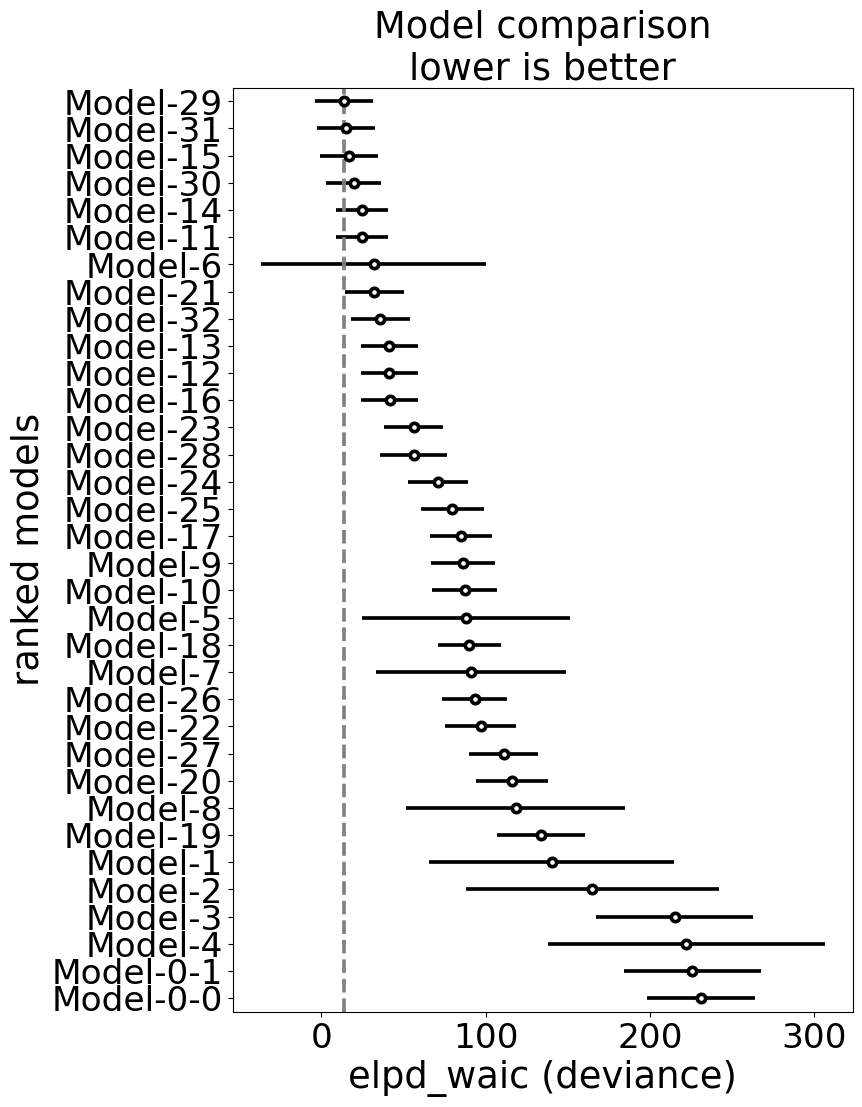

In [156]:
dict_idata = {'Model-0-0':idata_0_0,'Model-0-1':idata_0_1,
              'Model-1':idata_1, 'Model-2':idata_2, 
              'Model-3':idata_3, 'Model-4':idata_4, 
              'Model-5':idata_5,'Model-6':idata_6, 
              'Model-7':idata_7,'Model-8':idata_8,
              'Model-9':idata_9, 'Model-10':idata_10, 
              'Model-11':idata_12, 'Model-12':idata_13, 
              'Model-13':idata_13,'Model-14':idata_14,
              'Model-15':idata_15,'Model-16':idata_16,
              'Model-17':idata_17, 'Model-18':idata_18, 
              'Model-19':idata_19, 'Model-20':idata_20,
              'Model-21':idata_21,'Model-22':idata_22, 
              'Model-23':idata_23, 'Model-24':idata_24,
              'Model-25':idata_25, 'Model-26':idata_26, 
              'Model-27':idata_27, 'Model-28':idata_28,
              'Model-29':idata_29,'Model-30':idata_30, 
              'Model-31':idata_31, 'Model-32':idata_32}
df_waic = az.compare(dict_idata, ic='waic', scale='deviance')

az.plot_compare(df_waic, figsize=(8, 12))


In [152]:
params = ["alpha", "beta", "gamma", "delta", "rho", "rho_kappa", "rho_z"]

df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            row[param] = summary.loc[param, "mean"]
        else:
            row[param] = "-"

    summary_rhat = az.summary(idata)
    n_bad_rhat = (summary_rhat["r_hat"] > 1.05).sum()
    row["bad params(rhat>1.05)"] = n_bad_rhat
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,alpha,beta,gamma,delta,rho,rho_kappa,rho_z,bad params(rhat>1.05)
0,Model-0-0,-,0.960,-,-,-,-,-,0
1,Model-0-1,0.237,0.763,-,-,-,-,-,0
2,Model-1,-,0.947,0.589,-,-,-,-,0
3,Model-2,0.04,0.960,0.582,-,-,-,-,0
4,Model-3,-,0.960,-,-,0.178,-,-,32
5,Model-4,0.28,0.720,-,-,0.269,-,-,0
6,Model-5,-,0.951,0.519,-,0.168,-,-,0
7,Model-6,0.04,0.960,0.439,-,0.199,-,-,178
8,Model-7,-,0.962,0.56,0.15,0.159,-,-,0
9,Model-8,0.057,0.943,0.501,0.154,0.179,-,-,0


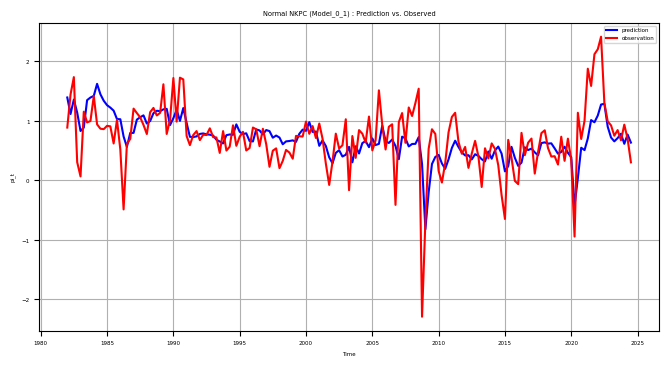

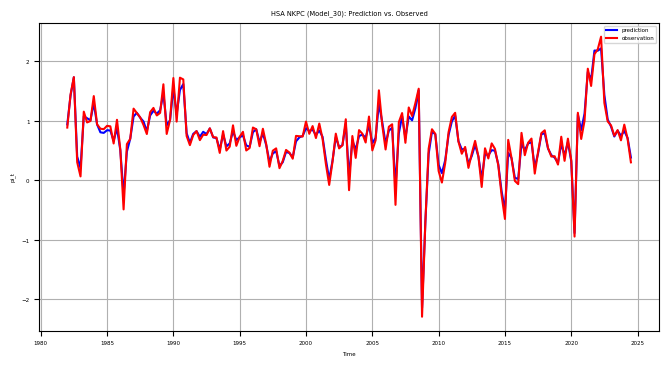

In [153]:
# Prediction Plot
plot_model("0_1", "Normal NKPC (Model_0_1) : Prediction vs. Observed", data)
plot_model("30",   "HSA NKPC (Model_30): Prediction vs. Observed", data)


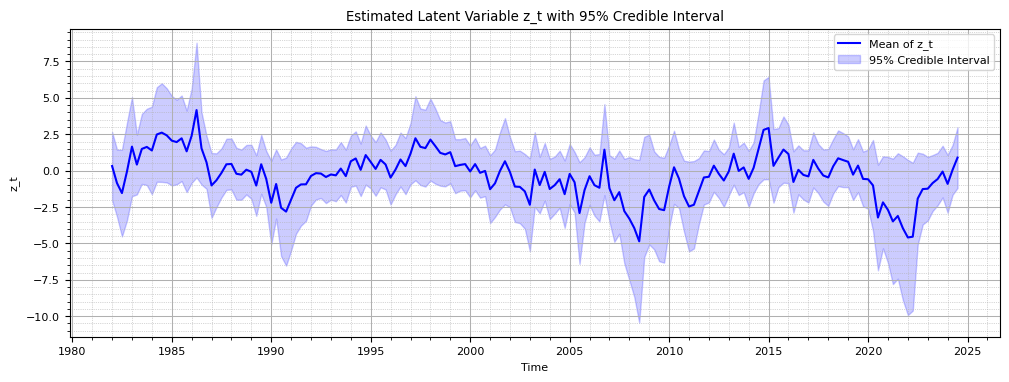

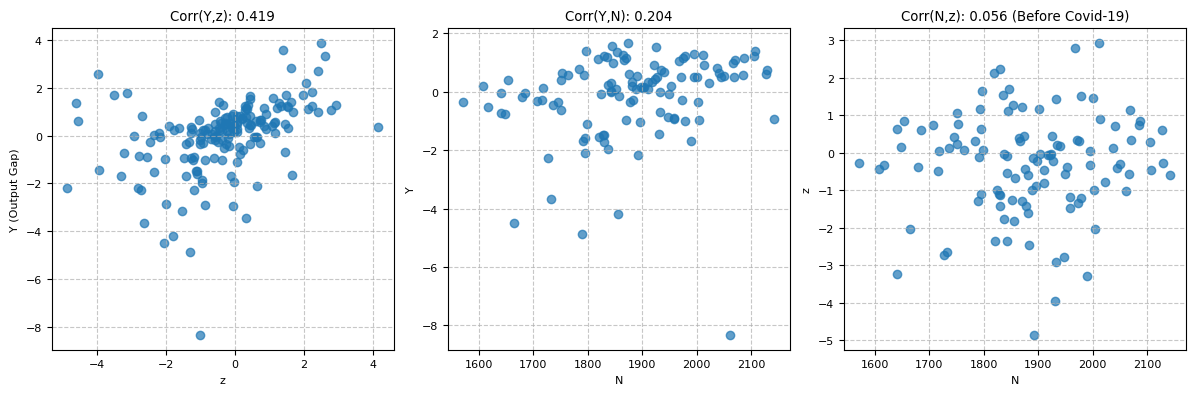

In [166]:
model_number = "29"
idata = globals()[f"idata_{model_number}"]
if "z" in idata.posterior.data_vars:
    z_mean_value =  globals()[f"z_mean_{model_number}"]
    z_lower =  globals()[f"z_lower_{model_number}"]
    z_upper =  globals()[f"z_upper_{model_number}"]
else:
    z_mean_value = np.zeros(len(data["DATE"]))
    z_lower =  np.zeros(len(data["DATE"]))
    z_upper =  np.zeros(len(data["DATE"]))

if "z" in idata.posterior.data_vars:
    z_mean_value =  globals()[f"z_mean_{model_number}"]
    z_lower =  globals()[f"z_lower_{model_number}"]
    z_upper =  globals()[f"z_upper_{model_number}"]
else:
    z_mean_value = np.zeros(len(data["DATE"]))
    z_lower =  np.zeros(len(data["DATE"]))
    z_upper =  np.zeros(len(data["DATE"]))
    
plt.rcParams.update({'font.size': 8}) 
df = data
df["z"] = z_mean_value
data_N = pd.read_csv("data/BLS-bd-BDS0000000000000000120001LQ5.csv")
data_N["N_end"] = data_N["National – Gross Job Gains – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120001LQ5)"]
data_N["N"] = data_N["N_end"].shift(1)
data_N['q'] = data_N["period"]
data_N["q"] = data_N["q"].str.replace(" ", "")
data_N["DATE"] = data_N["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_N = data_N[["DATE", "N"]]
df_merged = pd.merge(df, data_N, on="DATE", how="outer")
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged["DATE"]<'2020-09-01']

import matplotlib.dates as mdates
# print(f"Bayesian R^2: {r2}")
plt.figure(figsize=(12, 4))
plt.plot(data["DATE"], z_mean_value, label="Mean of z_t", color="blue")
plt.fill_between(data["DATE"], z_lower, z_upper, color="blue", alpha=0.2, label="95% Credible Interval")
plt.title("Estimated Latent Variable z_t with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("z_t")
plt.legend()
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth=0.75)
plt.grid(which='minor', linestyle=':', linewidth=0.5)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
corrcoef1 = np.corrcoef(z_mean_value, data["Y"])[0, 1]
axes[0].scatter(z_mean_value, data["Y"], alpha=0.7)
axes[0].set_xlabel("z")
axes[0].set_ylabel("Y (Output Gap)")
axes[0].set_title(f"Corr(Y,z): {corrcoef1:.3f}")
axes[0].grid(True, linestyle='--', alpha=0.7)

corrcoef2 = np.corrcoef(df_merged["N"], df_merged["Y"])[0, 1]
axes[1].scatter(df_merged["N"], df_merged["Y"], alpha=0.7)
axes[1].set_xlabel("N")
axes[1].set_ylabel("Y")
axes[1].set_title(f"Corr(Y,N): {corrcoef2:.3f}")
axes[1].grid(True, linestyle='--', alpha=0.7)

corrcoef3 = np.corrcoef(df_merged["N"], df_merged["z"])[0, 1]
axes[2].scatter(df_merged["N"], df_merged["z"], alpha=0.7)
axes[2].set_xlabel("N")
axes[2].set_ylabel("z")
axes[2].set_title(f"Corr(N,z): {corrcoef3:.3f} (Before Covid-19)")
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [176]:
df_list = []

data_N = pd.read_csv("data/BLS-bd-BDS0000000000000000120001LQ5.csv")
data_N["N_end"] = data_N["National – Gross Job Gains – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120001LQ5)"]
data_N["N"] = data_N["N_end"].shift(1)
data_N['q'] = data_N["period"]
data_N["q"] = data_N["q"].str.replace(" ", "")
data_N["DATE"] = data_N["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_N = data_N[["DATE", "N"]]

for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    if "z" in available_params:
        z_samples = idata.posterior["z"].values 
        z_mean = z_samples.mean(axis=(0, 1))     
        corr1 = np.corrcoef(Y, z_mean)[0, 1]
        row["corr_Y_z_mean"] = corr1
        df["z"] = z_mean
        df_merged = pd.merge(df, data_N, on="DATE", how="outer")
        df_merged = df_merged.dropna()
        df_merged = df_merged[df_merged["DATE"]<'2020-01-01']
        corr2 = np.corrcoef(df_merged["N"], df_merged["z"])[0, 1]
        row["corr_N_z_mean"] = corr2
    else:
        row["corr_Y_z_mean"] = "-"
        row["corr_N_z_mean"] = "-"
    df_list.append(row)
    
summary_df = pd.DataFrame(df_list)
display(summary_df)

,model,corr_Y_z_mean,corr_N_z_mean
0,Model-0-0,-,-
1,Model-0-1,-,-
2,Model-1,0.211076,-0.012648
3,Model-2,0.214504,-0.026828
4,Model-3,0.363358,0.103612
5,Model-4,0.525069,0.201779
6,Model-5,0.271458,0.028184
7,Model-6,0.18936,0.00078
8,Model-7,0.261483,0.019465
9,Model-8,0.29253,0.029726
